# INF421 — Path Planning Algorithms

**Membres**

- KAMDEM POUOKAM Ivann Harold — **PC**
- NGANTA Pacifique — **PC**

### Installation du projet

In [1]:
!pip install uv


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

if not os.path.exists("src/random_explorer"):
    !uv pip install git+https://www.github.com/KpihX/random-explorer.git
else:
    !uv pip install -e .

Resolved 56 packages in 12ms                                         
   Building random-explorer @ file:///home/kpihx/Work/X/random-explorer
      Built random-explorer @ file:///home/kpihx/Work/X/random-explorer
Prepared 1 package in 5ms                                                
Uninstalled 1 package in 0.47ms
Installed 1 package in 2ms1.0 (from file:///home/kpihx/Work/
 ~ random-explorer==0.1.0 (from file:///home/kpihx/Work/X/random-explorer)


In [3]:
from dotenv import load_dotenv
load_dotenv()

# Kaggle credentials for Colab
try:
    from google.colab import userdata
    os.environ["KAGGLE_API_TOKEN"] = userdata.get('KAGGLE_API_TOKEN')
except:
    pass

### Chargement des données

In [4]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np

# Download all scenarios
SCENARIOS = {}
for i in range(5):
    file = f"scenario{i}.txt"
    path = kagglehub.dataset_download(
        handle="ivannkamdem/random-explorer",
        path=file,
    )
    SCENARIOS[f"scenario{i}"] = path
    print(f"Loaded: {file} -> {path}")

# Default scenario for tests
file_path = SCENARIOS["scenario4"]

/home/kpihx/Work/X/random-explorer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded: scenario1.txt -> /home/kpihx/.cache/kagglehub/datasets/ivannkamdem/random-explorer/versions/1/scenario1.txt
Loaded: scenario2.txt -> /home/kpihx/.cache/kagglehub/datasets/ivannkamdem/random-explorer/versions/1/scenario2.txt
Loaded: scenario3.txt -> /home/kpihx/.cache/kagglehub/datasets/ivannkamdem/random-explorer/versions/1/scenario3.txt
Loaded: scenario4.txt -> /home/kpihx/.cache/kagglehub/datasets/ivannkamdem/random-explorer/versions/1/scenario4.txt


---

## Partie 3 : Particle Swarm Optimization (PSO)

---

### Question 1 : Initialisation de l'environnement

On implémente une classe `Environment` qui :
1. Parse le fichier de scénario (format décrit dans le README)
2. Valide les données (obstacles dans les limites, positions start/goal valides)
3. Fournit une méthode `is_collision(point)` pour la détection de collision

**Choix d'implémentation :**
- Les obstacles sont stockés comme tuples `(x, y, width, height)`
- La validation vérifie que start/goal ne sont pas dans un obstacle
- Les bordures des obstacles sont considérées comme collisions

In [5]:
from random_explorer import Environment

env = Environment(file_path)

print(f"Environment: {env.x_max} x {env.y_max}")
print(f"Start: {env.start}")
print(f"Goal: {env.goal}")
print(f"Number of obstacles: {len(env.obstacles)}")

Environment: 1000.0 x 1000.0
Start: (0.0, 0.0)
Goal: (1000.0, 1000.0)
Number of obstacles: 11


### Question 2 : Visualisation de l'environnement

La méthode `plot_environment()` affiche :
- Les limites de l'environnement
- Les obstacles (rectangles noirs)
- Le point de départ (cercle vert)
- Le point d'arrivée (croix rouge)
- Optionnellement un chemin (ligne bleue)

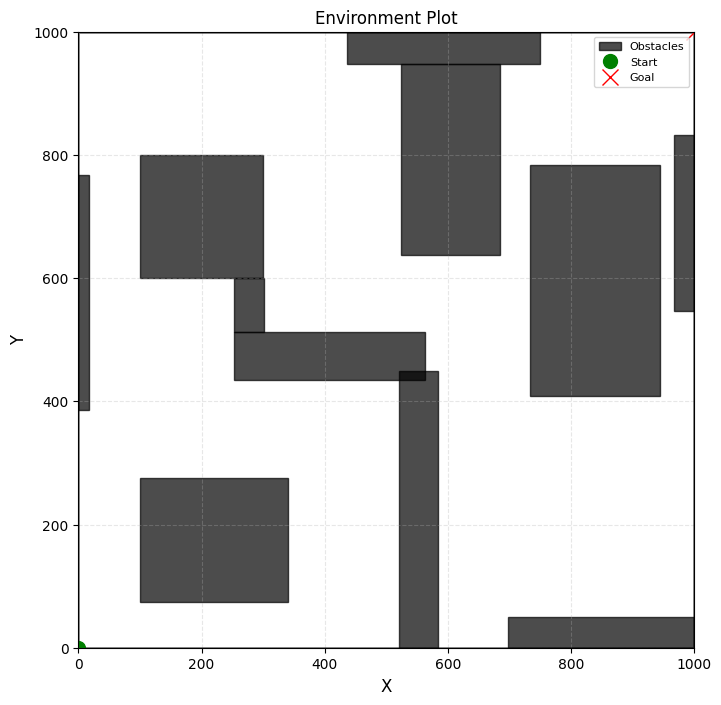

In [6]:
fig, ax = env.plot_environment()
plt.show()

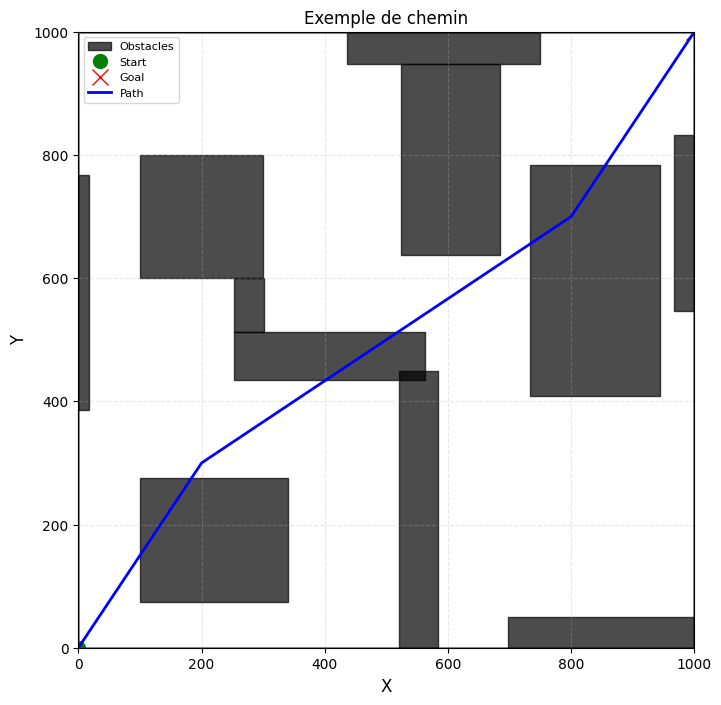

In [7]:
example_path = [(0, 0), (200, 300), (500, 500), (800, 700), (1000, 1000)]
fig, ax = env.plot_environment(path=example_path, title="Exemple de chemin")
plt.show()

### Question 3 : Définition des particules, fonction de fitness et structure de données

**1. Définition d'une particule**

Dans le contexte de la planification de trajectoire, une particule représente **un chemin complet candidat**, modélisé par $N$ waypoints intermédiaires :

$$u_s \rightarrow w_1 \rightarrow w_2 \rightarrow ... \rightarrow w_N \rightarrow u_d$$

**2. Fonction de Fitness**

$$f(x_i) = \text{Longueur}(x_i) + \text{Pénalité}(x_i)$$

**3. Structure de données (NumPy)**

- **Positions $X$** : Matrice $(S, N, 2)$
- **Vitesses $V$** : Matrice $(S, N, 2)$
- **Meilleurs locaux $P_{best}$** : Matrice $(S, N, 2)$
- **Meilleur global $G_{best}$** : Matrice $(N, 2)$

### Question 4 : Méthode de détection de collision

Nous avons implémenté deux méthodes de détection de collision, unifiées par une même formule de pénalité :

**Formule unifiée :**
$$\text{Fitness}(x_i) = L_{path} + P_{base} \cdot \mathbb{1}_{\{C > 0\}} + P_{collision} \cdot C$$

Où :
- $L_{path}$ = longueur géométrique du chemin
- $C$ = métrique de collision (dépend du mode)
- $P_{base}$ = pénalité de base si collision (ex: 1000)
- $P_{collision}$ = pénalité par unité de collision (ex: 100)

---

**Mode Hard (échantillonnage) :**

Échantillonner $p$ points le long de chaque segment et compter le nombre de segments en collision.

$$C_{hard} = \sum_{j=1}^{N+1} \mathbb{1}_{\{\text{segment}_j \text{ en collision}\}}$$

*Simple mais approximatif (dépend de la résolution d'échantillonnage).*

---

**Mode Soft (intersection géométrique) :**

Calcul exact de la longueur d'intersection segment-obstacle via l'algorithme de clipping de Liang-Barsky.

$$C_{soft} = \sum_{j=1}^{N+1} \sum_{k=1}^{M} \text{overlap}(\text{segment}_j, \text{obstacle}_k)$$

*Plus précis : pénalise proportionnellement à la "profondeur" de pénétration.*

### Question 5 : Pseudo-code de l'algorithme PSO

**Note :** L'implémentation supporte les deux modes (`soft_mode=True/False`).  
La fonction `Fitness()` utilise la formule unifiée décrite en Q4.

---

```
Algorithme PSO_PathPlanning

// Initialisation
Pour i = 1..S:
    // Init de chaque particule
    X[i] = N points aléatoires dans [0, x_max] * [0, y_max]
    V[i] = [[0, 0]] * N
    P_best[i], P_best_score[i] = X[i], +∞
    G_best, G_best_score = None, +∞

// Boucle principale
Pour k = 1 à max_iter :
    // Évaluation
    Pour chaque particule i :
        score = Fitness(X[i])
        Si score < P_best_score[i] : 
            P_best_score[i] = score
            P_best[i] = copy(X[i])
        
            Si score < G_best_score : 
                G_best_score  = score
                G_best = copy(X[i])
    
    // Mise à jour cinématique
    // r1, r2 = matrices aléatoires de forme (S, N, 2) avec valeurs dans [0, 1]
    r1 = Random(0, 1, taille=(S, N, 2))
    r2 = Random(0, 1, taille=(S, N, 2))
    V = w*V + c1*r1*(P_best - X) + c2*r2*(G_best - X)
    X = Clip(X + V, bornes)

Retourner [Start] + G_best + [Goal]
```

### Question 6 : Analyse de complexité

**Notations :**
- $K$ : nombre d'itérations
- $S$ : nombre de particules
- $N$ : nombre de waypoints par particule (donc $N+1$ segments)
- $M$ : nombre d'obstacles

---

**Mode Soft (intersection géométrique exacte) :**

1. **Calcul de la longueur du chemin :**
   - Pour chaque particule : $(N+1)$ segments → $O(N)$ opérations
   - Pour toutes les particules : $O(S \cdot N)$

2. **Calcul de la pénalité (cœur de la complexité) :**
   - Pour chaque segment, on calcule l'intersection exacte avec chaque obstacle via intersection paramétrique (clipping de Liang-Barsky) : $O(1)$ par test
   - Par segment : $O(M)$ tests
   - Par particule ($N+1$ segments) : $O(N \cdot M)$
   - Pour toutes les particules : $O(S \cdot N \cdot M)$

3. **Mise à jour des vitesses et positions :**
   - Opérations vectorielles élémentaires sur matrices $(S, N, 2)$ : $O(S \cdot N)$

**Complexité par itération (soft) :** $O(S \cdot N \cdot M)$ *(dominée par l'évaluation fitness)*

**Complexité totale (soft) :** $\boxed{O(K \cdot S \cdot N \cdot M)}$

---

**Mode Hard (échantillonnage) — en comparaison :**

Soit $p$ le nombre de points échantillonnés par segment.

1. **Calcul de la longueur :** identique → $O(S \cdot N)$

2. **Calcul de la pénalité :**
   - Pour chaque segment : échantillonner $p$ points et vérifier chaque point contre $M$ obstacles
   - Test point-dans-rectangle : $O(1)$
   - Par segment : $O(p \cdot M)$
   - Par particule : $O(N \cdot p \cdot M)$
   - Pour toutes les particules : $O(S \cdot N \cdot p \cdot M)$

**Complexité totale (hard) :** $\boxed{O(K \cdot S \cdot N \cdot p \cdot M)}$

---

**Comparaison :**

| Aspect | Mode Soft | Mode Hard |
|--------|-----------|-----------|
| Complexité | $O(K \cdot S \cdot N \cdot M)$ | $O(K \cdot S \cdot N \cdot p \cdot M)$ |
| Facteur supplémentaire | — | $\times p$ |
| Précision | Exacte | Approximative (dépend de $p$) |
| Constantes cachées | Plus élevées (calculs géométriques) | Plus faibles |

**Conclusion :** Le mode soft est asymptotiquement plus efficace ($p$ fois moins d'opérations) **et** plus précis. Le mode hard nécessiterait un $p$ élevé pour être précis, ce qui dégrade ses performances.

### Question 7 : Implémentation

In [8]:
# Top 7 configurations from grid search (scenarios 3 & 4)
# Rank 1: 100% success, avg_length=1894.0
pso_params_1 = {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.8, 'c1': 1.6, 'c2': 1.0}
# Rank 2: 100% success, avg_length=2072.3
pso_params_2 = {'num_particles': 250, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.85, 'c1': 1.4, 'c2': 0.8}
# Rank 3: 100% success, avg_length=3714.8
pso_params_3 = {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.85, 'c1': 1.6, 'c2': 1.4}
# Rank 4: 75% success, avg_length=1848.1
pso_params_4 = {'num_particles': 400, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.7, 'c1': 1.6, 'c2': 0.8}
# Rank 5: 75% success, avg_length=2101.1
pso_params_5 = {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.85, 'c1': 1.0, 'c2': 1.4}
# Rank 6: 75% success, avg_length=2602.8
pso_params_6 = {'num_particles': 400, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.5, 'c1': 1.6, 'c2': 1.6}
# Rank 7: 50% success, avg_length=1551.0
pso_params_7 = {'num_particles': 400, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.7, 'c1': 1.2, 'c2': 1.0}

In [ ]:
from random_explorer import PSOPathPlanner

file_path = SCENARIOS["scenario4"]
env = Environment(file_path)

pso_params = pso_params_1

pso = PSOPathPlanner(env, **pso_params)

path, path_length, score, history = pso.solve(soft_mode=True)
print(f"Score final: {score:.2f}, Longueur: {path_length:.2f}")

Score final: 2255.26, Longueur: 2255.26


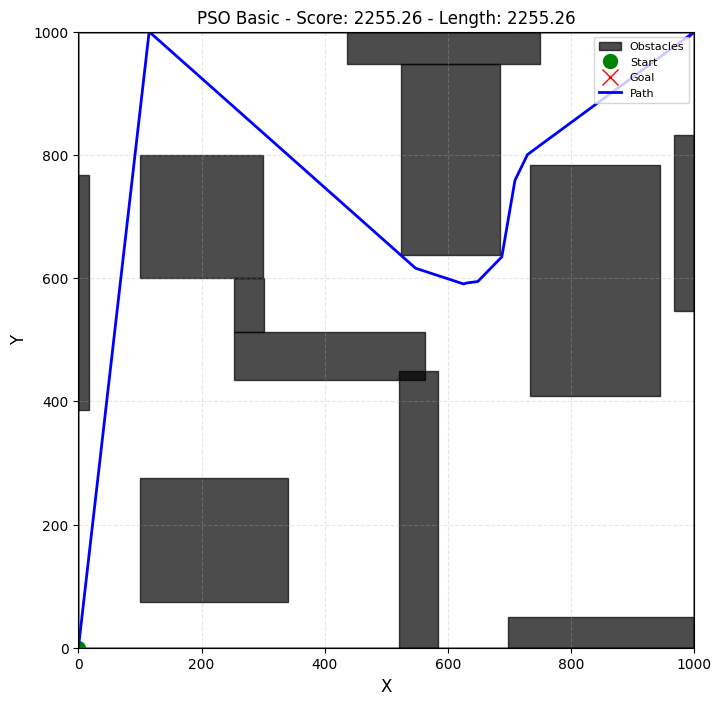

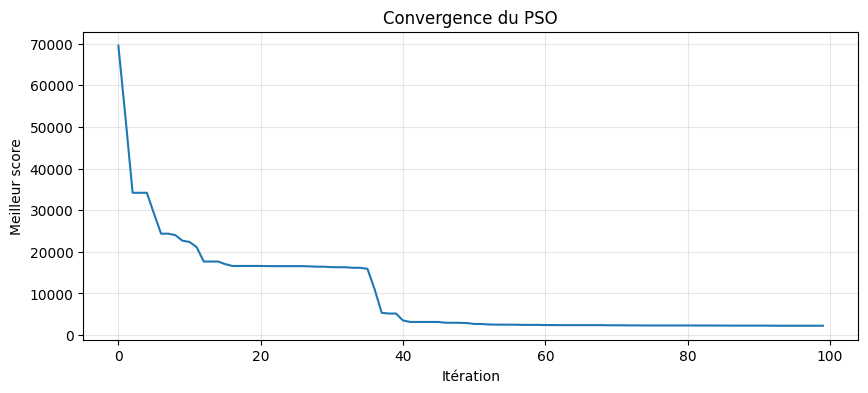

In [367]:
fig, ax = env.plot_environment(path=path, title=f"PSO Basic - Score: {score:.2f} - Length: {path_length:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(history)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Convergence du PSO')
plt.grid(True, alpha=0.3)
plt.show()

### Question 8 : Performances sur tous les scénarios

**Hyperparamètres retenus :** Meilleure config du grid search (`pso_params_1`)

In [372]:
from random_explorer import Benchmark

benchmark = Benchmark()

PSO_PARAMS = pso_params_1  # Best config from grid search

print("Benchmark PSO sur tous les scénarios")
print(f"Params: S={PSO_PARAMS['num_particles']}, N={PSO_PARAMS['num_waypoints']}, max_iter={PSO_PARAMS['max_iter']}")
print("="*60)

pso_results = {}
for name, scenario_path in SCENARIOS.items():
    env_test = Environment(scenario_path)
    result = benchmark.run_pso(env_test, params=PSO_PARAMS)
    result.scenario = name
    pso_results[name] = result
    
    valid_str = "✓" if result.is_valid else "✗"
    print(f"{name}: Length={result.path_length:.2f}, Valid={valid_str}, Time={result.cpu_time:.3f}s")

Benchmark PSO sur tous les scénarios
Params: S=300, N=8, max_iter=100
scenario0: Length=1443.45, Valid=✓, Time=2.197s
scenario1: Length=2000.00, Valid=✓, Time=1.882s
scenario2: Length=2479.40, Valid=✓, Time=11.167s
scenario3: Length=1544.86, Valid=✓, Time=8.470s
scenario4: Length=2161.36, Valid=✓, Time=10.247s


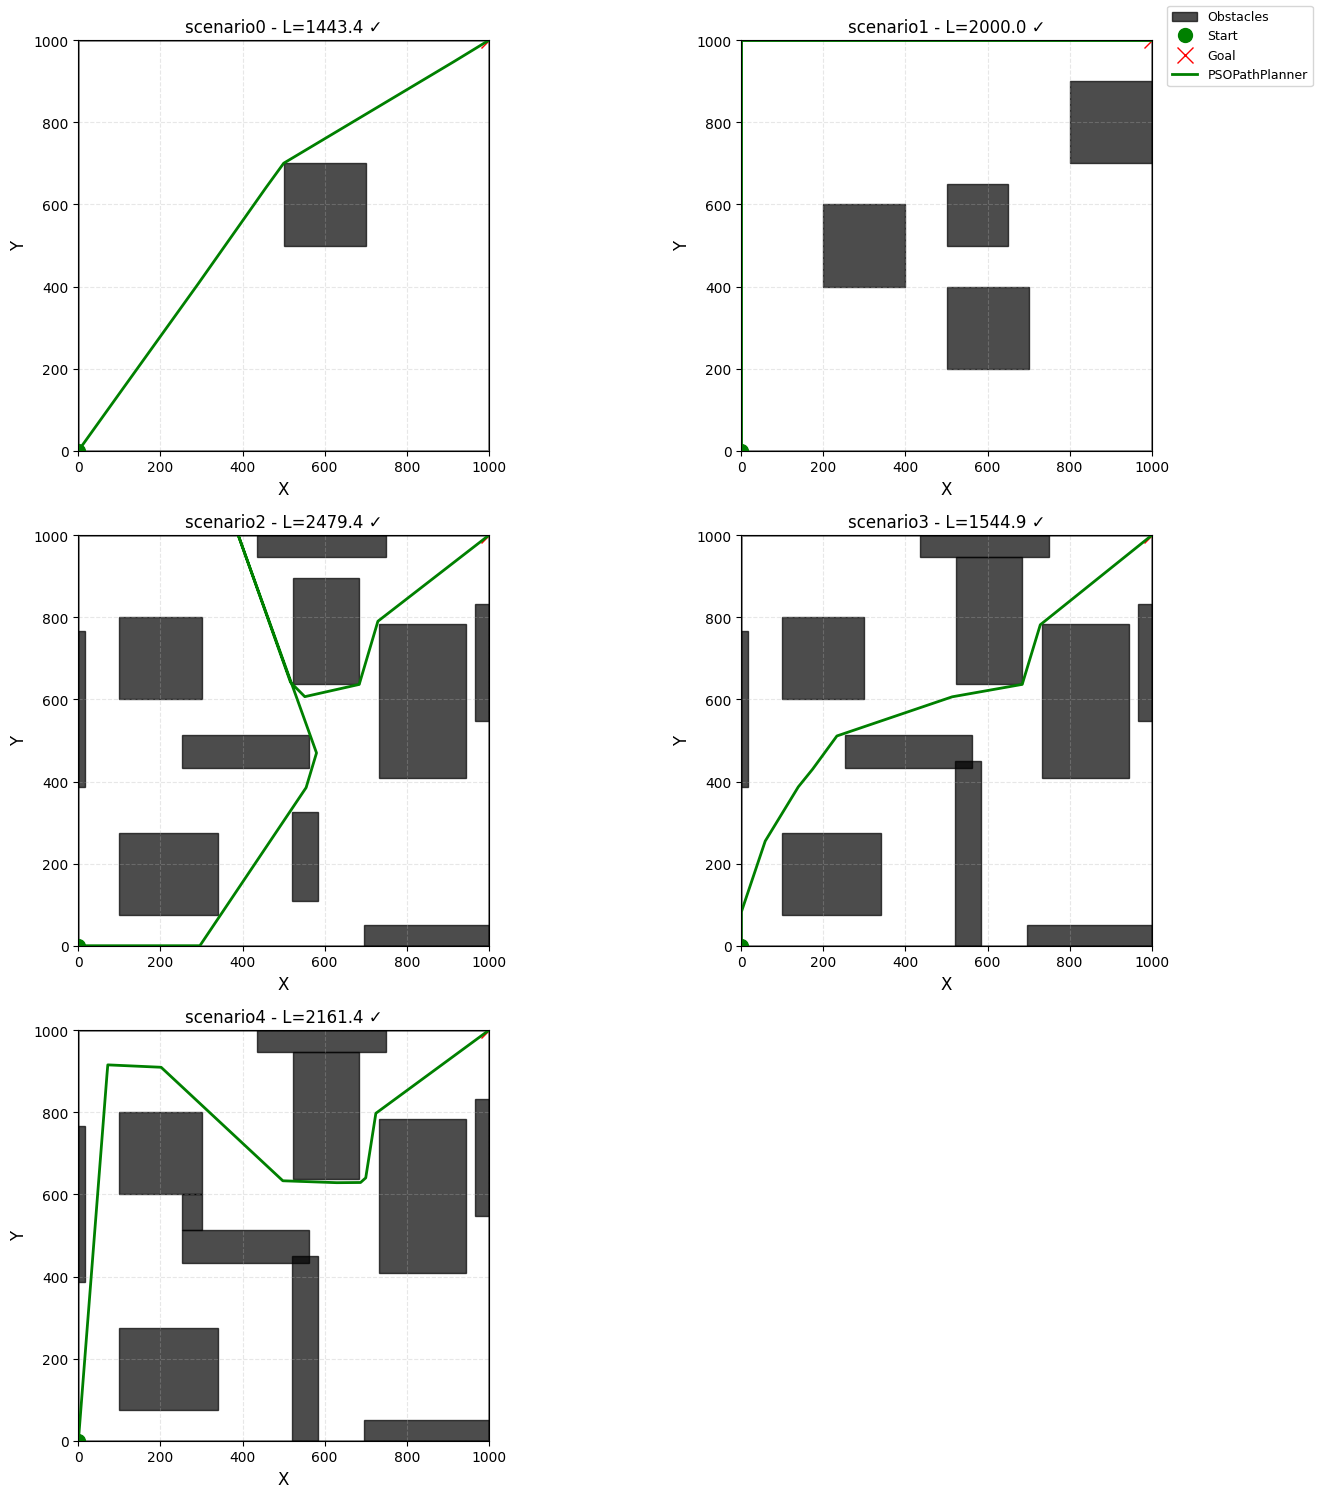

In [373]:
# Visualisation des chemins PSO pour tous les scénarios
envs = {name: Environment(path) for name, path in SCENARIOS.items()}
benchmark.plot_results_grid(pso_results, envs, n_cols=2)
plt.show()

---

## Partie 3.2 : Améliorations du PSO

---

### Question 9 : Random Restart

Réinitialise périodiquement les particules (sauf les élites) pour explorer de nouvelles régions.

**Hyperparamètres :** `restart_frequency=50`, `elite_ratio=0.1`

In [465]:
from random_explorer import PSORestart

file_path = SCENARIOS["scenario4"]
env = Environment(file_path)

pso_params = pso_params_1
pso_params["num_particles"] = 250
pso_params["w"] = 0.85
pso_params["c1"] = 1.6
pso_params["c2"] = 1.1

pso_restart = PSORestart(
    env, **pso_params,
    restart_frequency=50, elite_ratio=0.4
)

path_restart, length_restart, score_restart, history_restart = pso_restart.solve(soft_mode=True)
print(f"PSO Restart - Score: {score_restart:.2f}, Length: {length_restart:.2f}, Restarts: {pso_restart.num_restarts}")

PSO Restart - Score: 2361.55, Length: 2361.55, Restarts: 1


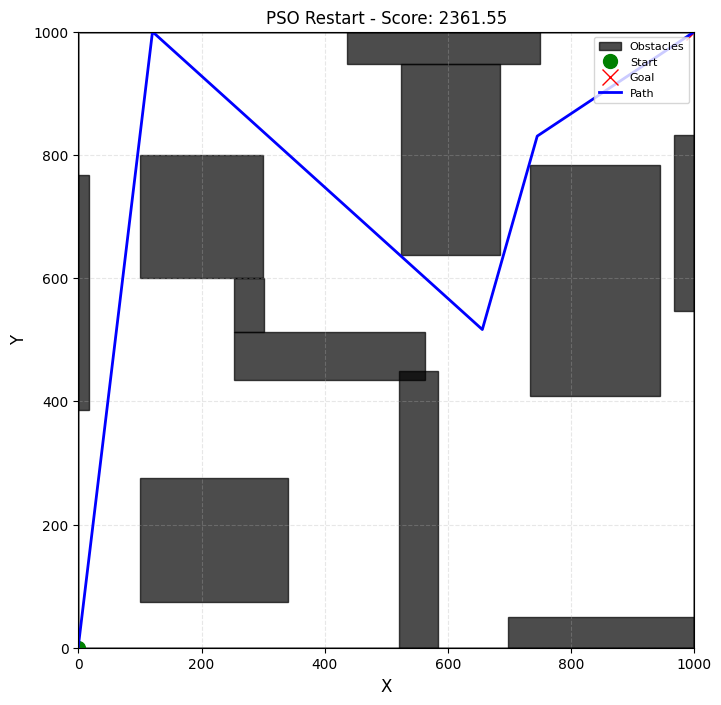

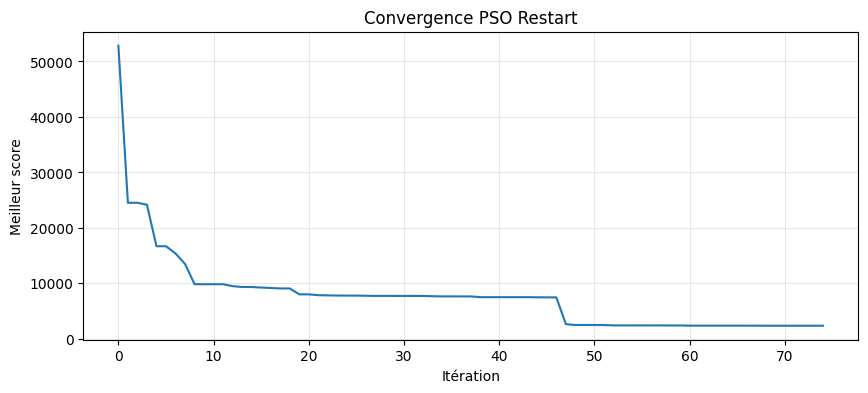

In [466]:
fig, ax = env.plot_environment(path=path_restart, title=f"PSO Restart - Score: {score_restart:.2f}")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_restart)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Convergence PSO Restart')
plt.grid(True, alpha=0.3)
plt.show()

### Question 10 : Simulated Annealing

Accepte parfois des solutions moins bonnes avec probabilité $p = e^{-\Delta/T}$.

**Hyperparamètres :** `T0=1000`, `beta=0.95`

In [479]:
from random_explorer import PSOSimulatedAnnealing

file_path = SCENARIOS["scenario4"]
env = Environment(file_path)

pso_params = pso_params_1
pso_params["num_particles"] = 250
pso_params["w"] = 0.85
pso_params["c1"] = 1.6
pso_params["c2"] = 1.0

pso_sa = PSOSimulatedAnnealing(
    env, **pso_params,
    T0=50.0, beta=0.9,
    restart_frequency=50, elite_ratio=0.7
)

path_sa, length_sa, score_sa, history_sa = pso_sa.solve(restart=False, soft_mode=True)
print(f"PSO SA - Score: {score_sa:.2f}, Length: {length_sa:.2f}")

PSO SA - Score: 2404.59, Length: 2404.59


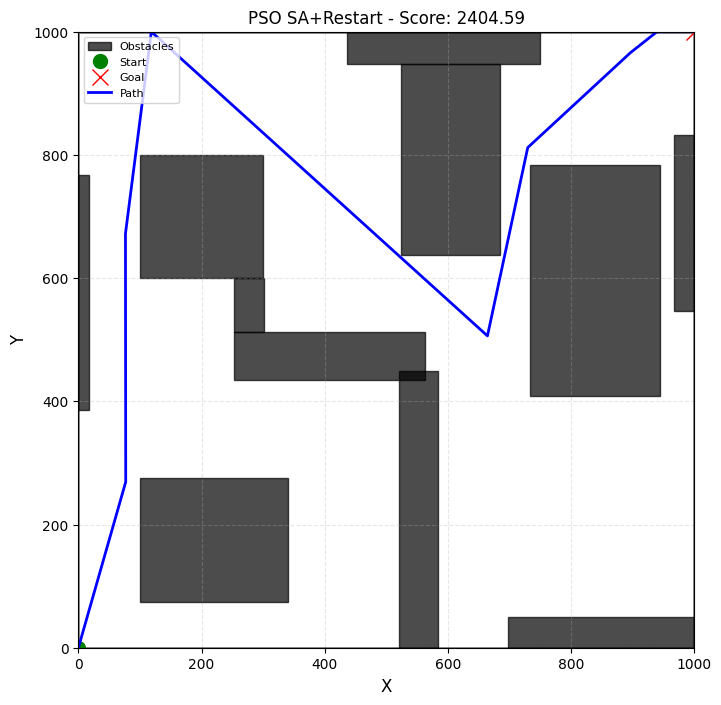

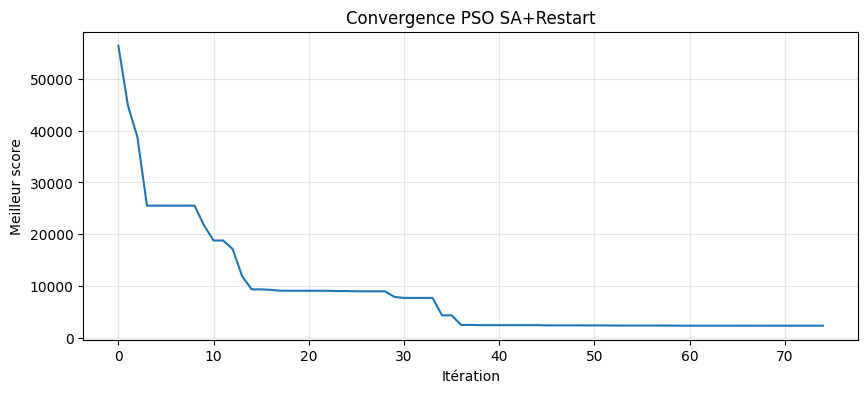

In [490]:
fig, ax = env.plot_environment(path=path_sa, title=f"PSO SA+Restart - Score: {score_sa:.2f}")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_sa)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Convergence PSO SA+Restart')
plt.grid(True, alpha=0.3)
plt.show()

### Question 11 : Dimensional Learning

Si une particule stagne, améliore son $P_{best}$ dimension par dimension depuis $G_{best}$.

**Hyperparamètre :** `wait_limit=10`

In [503]:
from random_explorer import PSODimensionalLearning

file_path = SCENARIOS["scenario4"]
env = Environment(file_path)

pso_params = pso_params_2
pso_params["num_waypoints"] = 8
pso_params["c2"] = 1.0

pso_dl = PSODimensionalLearning(
    env, **pso_params,
    wait_limit=50,
    T0=100, beta=0.7, 
    restart_frequency=50, elite_ratio=0.9 
)

path_dl, length_dl, score_dl, history_dl = pso_dl.solve(simulated_annealing=False, restart=False, soft_mode=True)
print(f"PSO DL - Score: {score_dl:.2f}, Length: {length_dl:.2f}")

PSO DL - Score: 2240.20, Length: 2240.20


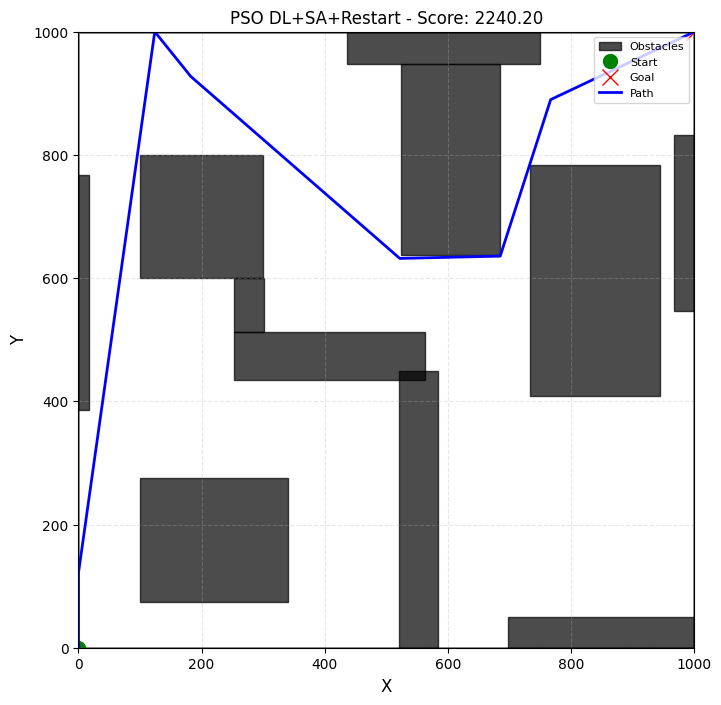

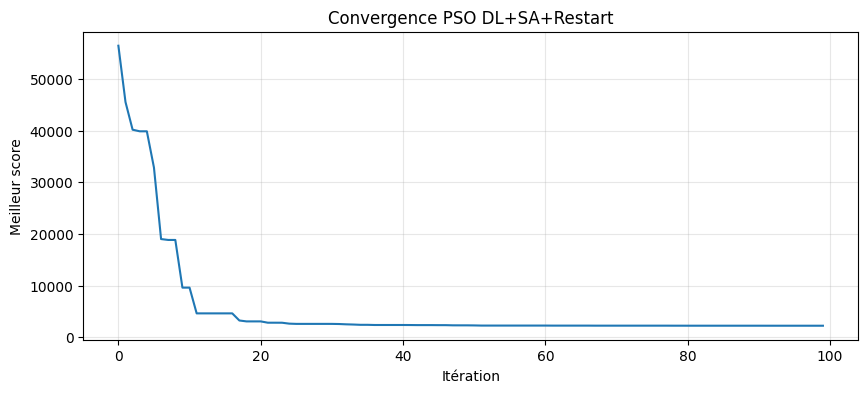

In [504]:
fig, ax = env.plot_environment(path=path_dl, title=f"PSO DL+SA+Restart - Score: {score_dl:.2f}")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_dl)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Convergence PSO DL+SA+Restart')
plt.grid(True, alpha=0.3)
plt.show()

### Question 12 : Amélioration propre - Adaptive Inertia + Early Stopping

**1. Inertie adaptative :**
Le poids d'inertie décroît linéairement : $w(k) = w_{max} - (w_{max} - w_{min}) \cdot \frac{k}{K}$

Cela favorise l'exploration au début et l'exploitation à la fin.

**2. Arrêt anticipé (Early Stopping) :**
On s'arrête dès qu'un chemin **valide** est trouvé, i.e. quand $\text{score} = \text{longueur}$ (aucune pénalité de collision).

**Justification :**
- PSO n'offre aucune garantie d'optimalité (le plus court chemin)
- Les courbes de convergence montrent de longs paliers (parfois 100+ itérations sans amélioration)
- Dès qu'un chemin valide est trouvé, continuer a peu de chances d'améliorer significativement

**Paramètres supplémentaires :** `dimensional_learning=True/False` pour activer/désactiver le DL.

In [517]:
from random_explorer import PSOAdaptiveInertia

pso_params = pso_params_1
# pso_params["max_iter"] = 100
pso_params["num_waypoints"] = 9

# Remove 'w' from params since we use w_max/w_min
adaptive_params = {k: v for k, v in pso_params.items() if k != 'w'}

pso_adaptive = PSOAdaptiveInertia(
    env, **adaptive_params,
    w_max=0.9, w_min=0.4,
    wait_limit=25,
    T0=100, beta=0.7, 
    restart_frequency=30, elite_ratio=0.5
)

path_adaptive, length_adaptive, score_adaptive, history_adaptive = pso_adaptive.solve(
    soft_mode=True, 
    restart=False, 
    simulated_annealing=False,
    dimensional_learning=False
)

is_valid = np.isclose(score_adaptive, length_adaptive)
valid_str = "✓ valide" if is_valid else "✗ collision"
print(f"PSO Adaptive - Score: {score_adaptive:.2f}, Length: {length_adaptive:.2f}")
print(f"Itérations: {len(history_adaptive)}/{pso_adaptive.max_iter} ({valid_str})")

PSO Adaptive - Score: 3044.73, Length: 3044.73
Itérations: 77/100 (✓ valide)


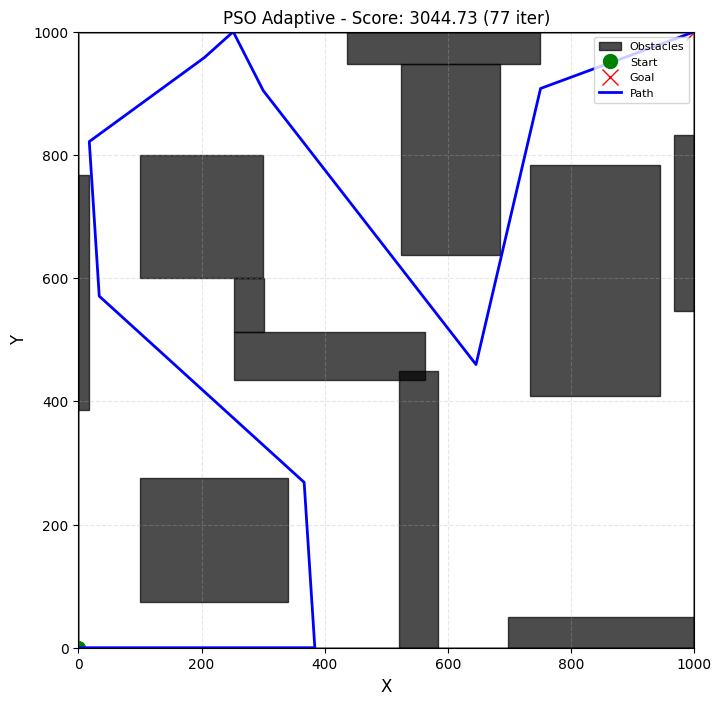

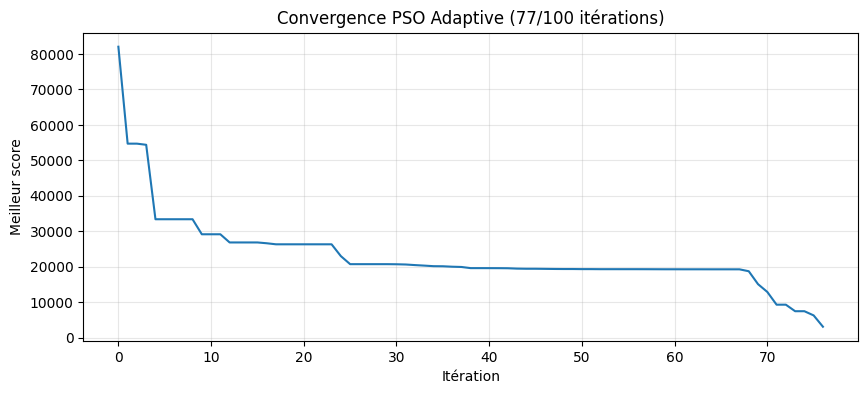

In [518]:
fig, ax = env.plot_environment(path=path_adaptive, title=f"PSO Adaptive - Score: {score_adaptive:.2f} ({len(history_adaptive)} iter)")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_adaptive)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title(f'Convergence PSO Adaptive ({len(history_adaptive)}/{pso_adaptive.max_iter} itérations)')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Configuration et benchmark de toutes les variantes PSO sur un scénario ajustable
from random_explorer import Benchmark
import numpy as np

scenario = SCENARIOS["scenario2"]  
env = Environment(scenario)

benchmark = Benchmark()
pso_params = pso_params_1  # Best config from grid search

# Run all PSO variants with same base params
pso_variant_results = benchmark.run_all_pso_variants(env, pso_params)

print(f"Benchmark de toutes les variantes PSO sur {scenario}")
print(f"Base params: {pso_params}")
print("=" * 60)

Benchmark de toutes les variantes PSO sur /home/kpihx/.cache/kagglehub/datasets/ivannkamdem/random-explorer/versions/1/scenario2.txt
Base params: {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.8, 'c1': 1.6, 'c2': 1.0}


In [ ]:
# Visualisation des chemins pour chaque variante 

fig = benchmark.plot_results_grid(
    results=pso_variant_results,
    envs={name: env for name in pso_variant_results.keys()},
    n_cols=2,
)
plt.suptitle("Comparaison des chemins - Variantes PSO", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

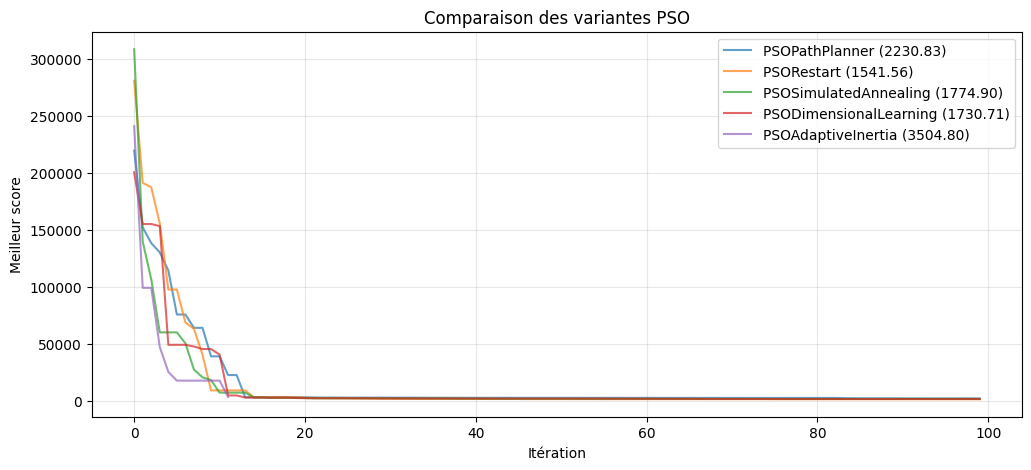

╭───────────────────────────────────────── Comparaison des variantes PSO ─────────────────────────────────────────╮
│ Algorithm                      Score     Length  Valid   Iter   Time (s)                                        │
│ ------------------------------------------------------------------------                                        │
│ PSORestart                   1541.56    1541.56      ✓    100    11.4816                                        │
│ PSODimensionalLearning       1730.71    1730.71      ✓    100     9.4728                                        │
│ PSOSimulatedAnnealing        1774.90    1774.90      ✓    100    10.4496                                        │
│ PSOPathPlanner               2230.83    2230.83      ✓    100    11.6967                                        │
│ PSOAdaptiveInertia           3504.80    3504.80      ✓     12     2.3474                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
# Comparaison des variantes PSO - Convergence
plt.figure(figsize=(12, 5))
for name, result in pso_variant_results.items():
    if result.history:
        label = f"{name} ({result.score:.2f})" if result.score else name
        plt.plot(result.history, label=label, alpha=0.7)

plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Comparaison des variantes PSO')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Récapitulatif des performances PSO (utilisant display_results)
benchmark.display_results(
    list(pso_variant_results.values()),
    title="Comparaison des variantes PSO",
    sort_by='length'
)

---

## Partie 4 : Rapidly-exploring Random Tree (RRT*)

---

### Question 13 : Structure de données pour l'arbre

```python
class Node:
    x: float        # Coordonnée X
    y: float        # Coordonnée Y
    parent: Node    # Nœud parent (None pour la racine)
    cost: float     # Coût cumulé depuis la racine
```

**Arbre :** Liste de nœuds `List[Node]`

### Question 14 : Reconstruction du chemin

```
Fonction ReconstructPath(v):
    chemin = []
    Tant que v ≠ Null :
        chemin.ajouter(v.position)
        v = v.parent
    Retourner chemin.inverser()
```

**Complexité :** $O(h)$ où $h$ est la profondeur du nœud.

### Question 15 : Pseudo-code RRT*

```
Algorithme RRT_Star(Start, Goal, max_iter, δ_s, δ_r, goal_bias)

Entrées:
    Start       : Point de départ
    Goal        : Point d'arrivée
    max_iter    : Nombre maximal d'itérations
    δ_s (delta_s) : Distance maximale de steering (extension)
    δ_r (delta_r) : Rayon de recherche des voisins pour rewiring
    goal_bias   : Probabilité de choisir Goal comme cible (ex: 0.05) ; permets de rendre la convergence rapide, évitant une exploration uniforme de toute la carte

// Initialisation
Arbre = [Node(Start, parent=None, cost=0)]

// Boucle principale
Pour k = 1 à max_iter :

    // Échantillonnage biaisé vers le goal
    r = nombre aléatoire dans [0, 1]
    Si r < goal_bias :
        v_rand = Goal                    // Avec proba goal_bias, on cible le goal
    Sinon :
        v_rand = point aléatoire uniforme dans l'espace
    
    // Trouver le nœud le plus proche
    v_nearest = argmin_{v dans Arbre} distance(v, v_rand)
    
    // Steering : créer un nouveau point vers v_rand
    direction = (v_rand - v_nearest) / ||v_rand - v_nearest||
    distance_to_rand = min(||v_rand - v_nearest||, δ_s)
    v_new = v_nearest + direction * distance_to_rand
    
    // Vérification collision du segment
    Si segment(v_nearest, v_new) sans collision :
    
        // Choose Best Parent : chercher le meilleur parent parmi les voisins
        voisins = {v ∈ Arbre : distance(v, v_new) ≤ δ_r}
        best_parent = v_nearest
        best_cost = v_nearest.cost + distance(v_nearest, v_new)
        
        Pour chaque v ∈ voisins :
            Si segment(v, v_new) sans collision :
                cost_via_v = v.cost + distance(v, v_new)
                Si cost_via_v < best_cost :
                    best_parent = v
                    best_cost = cost_via_v
        
        // Ajouter v_new à l'arbre
        v_new.parent = best_parent
        v_new.cost = best_cost
        Arbre.ajouter(v_new)
        
        // Rewiring : améliorer les voisins si v_new offre un raccourci
        Pour chaque v ∈ voisins, v ≠ best_parent :
            Si segment(v_new, v) sans collision :
                new_cost = v_new.cost + distance(v_new, v)
                Si new_cost < v.cost :
                    v.parent = v_new
                    v.cost = new_cost

// Reconstruction du chemin
Retourner ReconstructPath(nœud le plus proche de Goal)
```

### Question 16 : Complexité d'une itération RRT*

Soit $n$ le nombre de nœuds actuellement dans l'arbre, $M$ le nombre d'obstacles.

#### Détail par étape :

| Étape | Opération | Complexité |
|-------|-----------|------------|
| 1. Échantillonnage | Générer un point aléatoire | $O(1)$ |
| 2. Nearest Neighbor | Trouver le nœud le plus proche (parcours naïf) | $O(n)$ |
| 3. Steering | Calculer `v_new` (opérations vectorielles) | $O(1)$ |
| 4. Collision segment | Tester collision avec $M$ obstacles | $O(M)$ |
| 5. Find Neighbors | Trouver voisins dans rayon $\delta_r$ | $O(n)$ |
| 6. Choose Best Parent | Tester collision pour chaque voisin (pire cas : tous) | $O(n \cdot M)$ |
| 7. Rewiring | Tester et mettre à jour les voisins | $O(n \cdot M)$ |

#### Complexité totale d'une itération :

$$\boxed{O(n \cdot M)}$$

- Le terme dominant est le **rewiring** et le **choose best parent**, car on teste potentiellement la collision de $O(n)$ segments avec $M$ obstacles.

#### Complexité totale sur $K$ itérations :

À l'itération $k$, l'arbre contient au plus $k$ nœuds, donc :

$$\sum_{k=1}^{K} O(k \cdot M) = O(M) \cdot \sum_{k=1}^{K} k = O(M \cdot K^2)$$

$$\boxed{O(K^2 \cdot M)}$$

**Note :** Avec un KD-tree pour le nearest neighbor et la recherche de voisins, on peut réduire à $O(K \cdot M \cdot \log K)$.

### Question 17 : Implémentation

In [11]:
from random_explorer import RRTPlanner

rrt = RRTPlanner(
    env,
    max_iter=5000,
    delta_s=30.0,
    delta_r=60.0,
    goal_bias=0.05,
    goal_tolerance=20.0
)

rrt_path, rrt_length, _ = rrt.solve()

if rrt_path:
    print(f"RRT* - Chemin trouvé! Longueur: {rrt_length:.2f}, Nœuds: {len(rrt.nodes)}")
else:
    print("RRT* - Pas de chemin trouvé")

RRT*: 100%|██████████| 5000/5000 [00:40<00:00, 124.08it/s]

RRT* - Chemin trouvé! Longueur: 1555.01, Nœuds: 3681


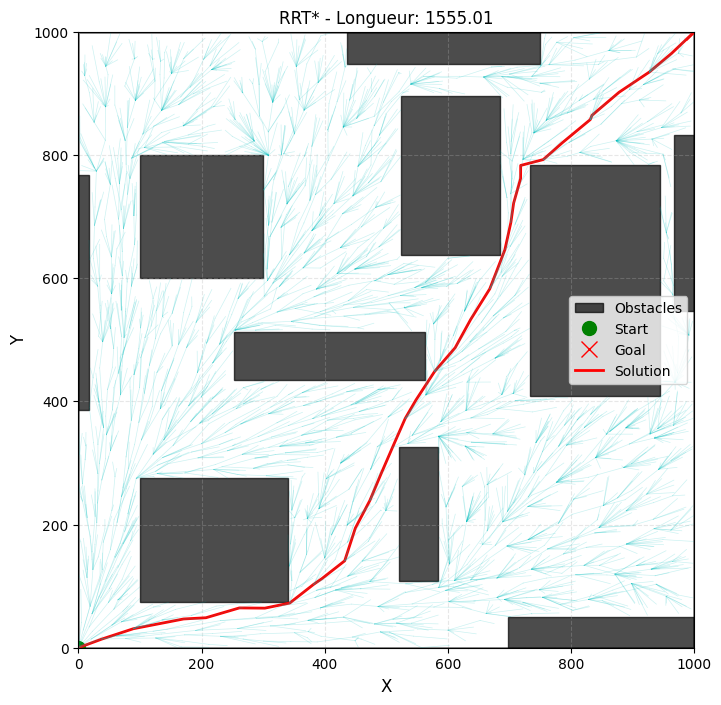

In [12]:
fig, ax = rrt.plot_tree(path=rrt_path, title=f"RRT* - Longueur: {rrt_length:.2f}")
plt.show()

### Question 18 : Performances sur tous les scénarios

In [13]:
print("Benchmark RRT* sur tous les scénarios")
print("="*60)

rrt_results = {}
for name, scenario_path in SCENARIOS.items():
    env_test = Environment(scenario_path)
    result = benchmark.run_rrt(env_test)
    result.scenario = name
    rrt_results[name] = result
    
    valid_str = "✓" if result.is_valid else "✗"
    length_str = f"{result.path_length:.2f}" if result.path_length < float('inf') else "N/A"
    print(f"{name}: Length={length_str}, Valid={valid_str}, Time={result.cpu_time:.3f}s")

Benchmark RRT* sur tous les scénarios
scenario0: Length=1572.59, Valid=✓, Time=7.594s
scenario1: Length=1615.43, Valid=✓, Time=7.055s
scenario2: Length=1627.39, Valid=✓, Time=5.418s
scenario3: Length=1837.56, Valid=✓, Time=4.357s
scenario4: Length=2460.86, Valid=✓, Time=2.715s


In [14]:
# Comparaison PSO vs RRT
print("\nComparaison PSO vs RRT*")
print("="*70)
print(f"{'Scénario':<12} {'PSO Length':>12} {'RRT Length':>12} {'PSO Time':>10} {'RRT Time':>10}")
print("-"*70)

for name in SCENARIOS.keys():
    pso_r = pso_results[name]
    rrt_r = rrt_results[name]
    pso_len = f"{pso_r.path_length:.2f}" if pso_r.path_length < float('inf') else "N/A"
    rrt_len = f"{rrt_r.path_length:.2f}" if rrt_r.path_length < float('inf') else "N/A"
    print(f"{name:<12} {pso_len:>12} {rrt_len:>12} {pso_r.cpu_time:>10.3f} {rrt_r.cpu_time:>10.3f}")


Comparaison PSO vs RRT*
Scénario       PSO Length   RRT Length   PSO Time   RRT Time
----------------------------------------------------------------------


NameError: name 'pso_results' is not defined

**Conclusion :**

| Aspect | PSO | RRT* |
|--------|-----|------|
| Fiabilité | Variable | Très fiable |
| Temps | Rapide | Plus lent |
| Paramétrage | Plus complexe | Simple |

RRT* est plus robuste pour les environnements complexes, PSO plus rapide sur les cas simples.